In [155]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, silhouette_score
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
import matplotlib
import h5py
from TDA_utils import cvb
from scipy.signal import spectrogram

#%matplotlib widget

In [2]:
datapath ="./Dlotko_dane/text_files/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
signal_list = []
for filename in sorted(filelist):
    signal_list.append(np.loadtxt(datapath+filename))

['good_cond_Gauss.txt', 'good_cond_Gauss_ch_b.txt', 'sig1a.txt', 'sig1b.txt', 'sig2a.txt', 'sig2b.txt', 'sig3a.txt', 'sig3b.txt']


In [3]:
minlengeth = min([len(s) for s in signal_list])
for i in range(len(signal_list)):
    signal_list[i] = signal_list[i][:minlengeth]

IndexError: list index out of range

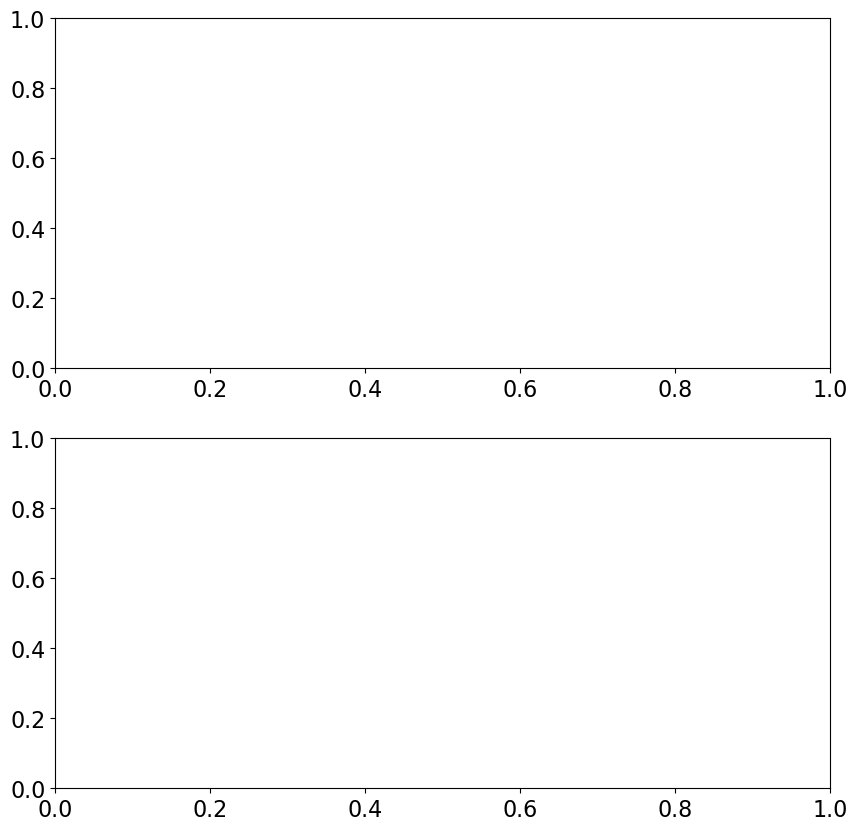

In [24]:
f,ax = plt.subplots(2,1, figsize =(10,10))
#ax[0].plot(signal_list[0])
#ax[0].plot(signal_list[2])

index0 = np.array_split(np.arange(len(signal_list[3])),n_samples)[0]
index26 = np.array_split(np.arange(len(signal_list[3])),n_samples)[26]
index29 = np.array_split(np.arange(len(signal_list[3])),n_samples)[29]
ax[1].plot(index0,signal_list[3][index0])
ax[1].plot(index26,signal_list[3][index26])
ax[1].plot(index29,signal_list[3][index29])
plt.show()

In [25]:
from gtda.time_series import takens_embedding_optimal_parameters
tau, dim = takens_embedding_optimal_parameters(signal_list[4],100,100, n_jobs = -1)
print(tau,dim)

KeyboardInterrupt: 

In [6]:
def compute_diagram(data, dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100):
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>250):
        skip = max(len(point_clouds)//250,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    #print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    return pd

In [245]:
n_samples = 10
norms = np.zeros((len(signal_list),n_samples))
start = 2.9
end = 3.5
grid = np.linspace(start,end,257)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((len(signal_list),n_samples,len(grid)))




for j in tqdm(range(0,len(signal_list))):
    #scaling_factor =(j+2)*0.5    
    dim = 96#29#105#95#55#132#66#432#int(90*(1/(scaling_factor)))
    delay = 98#40#97#98#880#50#100#63#452#int(120*(1/(scaling_factor)**2))#int(90*scaling_factor)
    
    #print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))
    
    skip =1
    samples = np.array_split(signal_list[j],n_samples)
        
    for k in range(0,len(samples)):
        pd = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100)
        if j == 0 or j == 1:
            print(pd)
        #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
        curve = np.array(bc.fit_transform([pd])[0])
        betti_curves[j,k] = curve
        #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
        norm = wasserstein_distance(pd,[], order=1, internal_p = 1)

        norms[j,k] = norm

  0%|          | 0/8 [00:00<?, ?it/s]

[[3.15572929 3.1560335 ]
 [3.15498616 3.1583912 ]
 [3.14310222 3.16165673]
 ...
 [3.14487848 3.29695403]
 [3.30189649 3.31621113]
 [3.30561666 3.34254979]]
[[3.16158029 3.17462933]
 [3.17865796 3.18177147]
 [3.1669743  3.18450311]
 ...
 [3.29406192 3.30556293]
 [3.30871917 3.31582351]
 [3.17289235 3.37166864]]
[[3.09601833 3.09720478]
 [3.09812737 3.09818861]
 [3.09588306 3.10071342]
 ...
 [3.16995269 3.19812777]
 [3.1730811  3.19874523]
 [3.19208008 3.20826244]]
[[3.08756895 3.0973011 ]
 [3.09221146 3.10431327]
 [3.10427272 3.11035862]
 ...
 [3.21900959 3.22762893]
 [3.22999426 3.23109372]
 [3.18977935 3.23468488]]
[[3.11798429 3.13328225]
 [3.12244538 3.13755054]
 [3.13431851 3.13808871]
 ...
 [3.12334037 3.24595221]
 [3.2435823  3.2471397 ]
 [3.27782988 3.29060221]]
[[3.11276507 3.12039732]
 [3.106056   3.12075503]
 [3.11507546 3.12194933]
 ...
 [3.20258059 3.24024099]
 [3.21764372 3.24603445]
 [3.22639272 3.25602588]]
[[3.11152803 3.11191001]
 [3.10886145 3.11425839]
 [3.10692942 3

In [234]:
#cvb

n_samples = 10
norms = np.zeros((len(signal_list),n_samples))
cvb_curves = np.zeros((len(signal_list),n_samples,257))




for j in tqdm(range(0,len(signal_list))):

    samples = np.array_split(signal_list[j],n_samples)
        
    for k in range(0,len(samples)):
        freqs, t, Pxx = spectrogram(samples[k], fs=25000, nfft=512, window="hamming", nperseg= 256, noverlap= int(np.floor(0.85*256)),detrend = False, mode="magnitude")
        curve =  np.array([cvb(np.abs(Pxx[i])) for i in range(0,len(freqs))])
        
        cvb_curves[j,k] = curve

  0%|          | 0/8 [00:00<?, ?it/s]

In [270]:
curves = np.concatenate([betti_curves, (np.max(betti_curves)/np.max(cvb_curves))*cvb_curves],axis = 2)
curves.shape

(8, 10, 514)

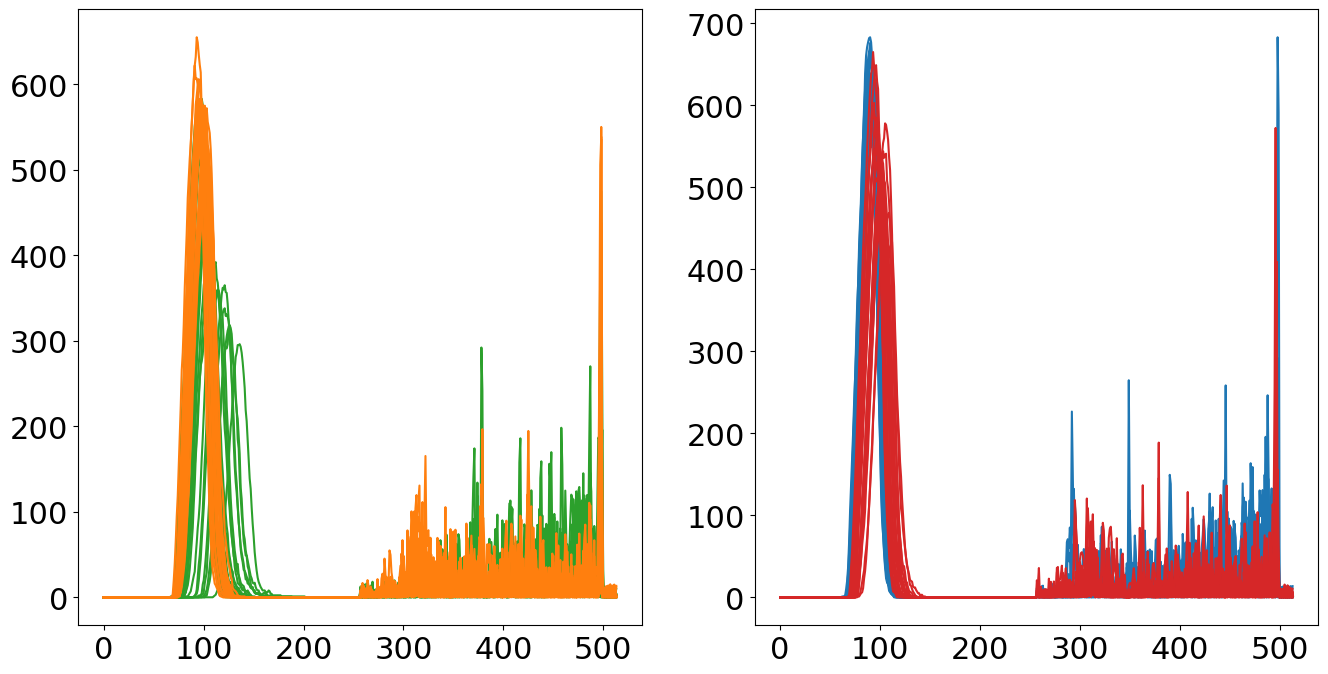

In [271]:
f,ax = plt.subplots(1,2,figsize=(16,8))
for j in [0,1,4,5]:
    for k in range(0,len(samples)):
        ax[0].plot( curves[j][k], color=colors[j//2])
for j in [2,3,6,7]:
    for k in range(0,len(samples)):
        ax[1].plot( curves[j][k], color=colors[j//2])
plt.show()

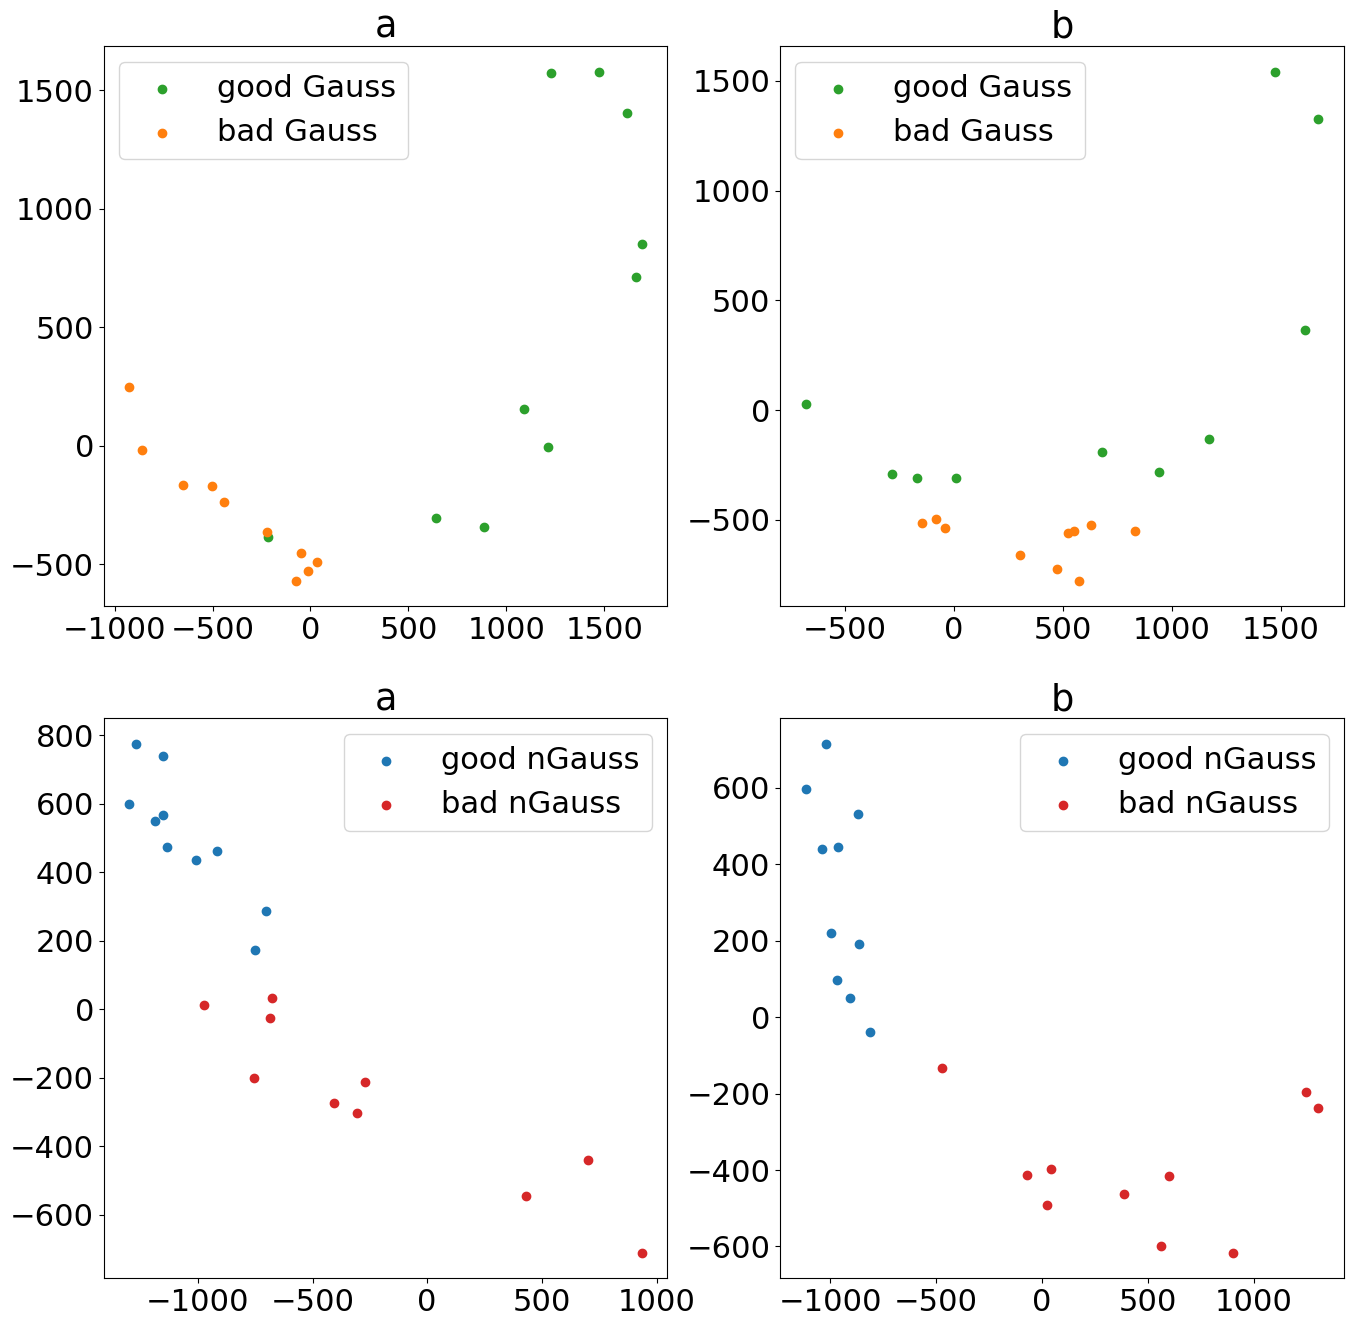

explained variance: [0.60384132 0.25119157 0.03219087]


ValueError: cannot reshape array of size 41120 into shape (80,257)

In [230]:
plt.rc('font', **{'size'   : 22})
pca = PCA(n_components=3)
pca.fit_transform([curves[j,k] for j in range(0,len(signal_list)) for k in range(0,n_samples)])
labels = np.repeat([1,2,3,4], 2*n_samples)
names = ["good Gauss", "good nGauss", "bad Gauss", "bad nGauss"]
fig,ax = plt.subplots(2,2,figsize=(16,16))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:green", "tab:blue", "tab:orange", "tab:red"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in [0,2]:
    
    emb_a = pca.transform(curves[2*i,:])
    ax[0,0].scatter(emb_a[:,0],emb_a[:,1], marker = "o", c=colors[i], label=names[i])    
    ax[0,0].set_title("a")
    ax[0,0].legend()
    
    emb_b = pca.transform(curves[2*i+1,:])
    ax[0,1].scatter(emb_b[:,0],emb_b[:,1], marker = "o", c=colors[i], label=names[i])
    ax[0,1].set_title("b")
    ax[0,1].legend()

for i in [1,3]:
    
    emb_a = pca.transform(curves[2*i,:])
    ax[1,0].scatter(emb_a[:,0],emb_a[:,1], marker = "o", c=colors[i], label=names[i])    
    ax[1,0].set_title("a")
    ax[1,0].legend()
    
    emb_b = pca.transform(curves[2*i+1,:])
    ax[1,1].scatter(emb_b[:,0],emb_b[:,1], marker = "o", c=colors[i], label=names[i])
    ax[1,1].set_title("b")
    ax[1,1].legend()
    
    
#for i in range(len(emb_a)):
#    ax[0].text(emb_a[i,0], emb_a[i,1], i)

#ax.flat[0].set_xlim(-550,50)
#ax.flat[0].set_ylim(-30,50)

#ax.flat[1].set_xlim(-20,20)
#ax.flat[1].set_ylim(-30,50)

plt.savefig("crusher_results/CrusherPCA.pdf")
plt.show()
print("explained variance:", pca.explained_variance_ratio_)
print("silhouette score",silhouette_score(curves.reshape(8*n_samples, len(grid)), labels))

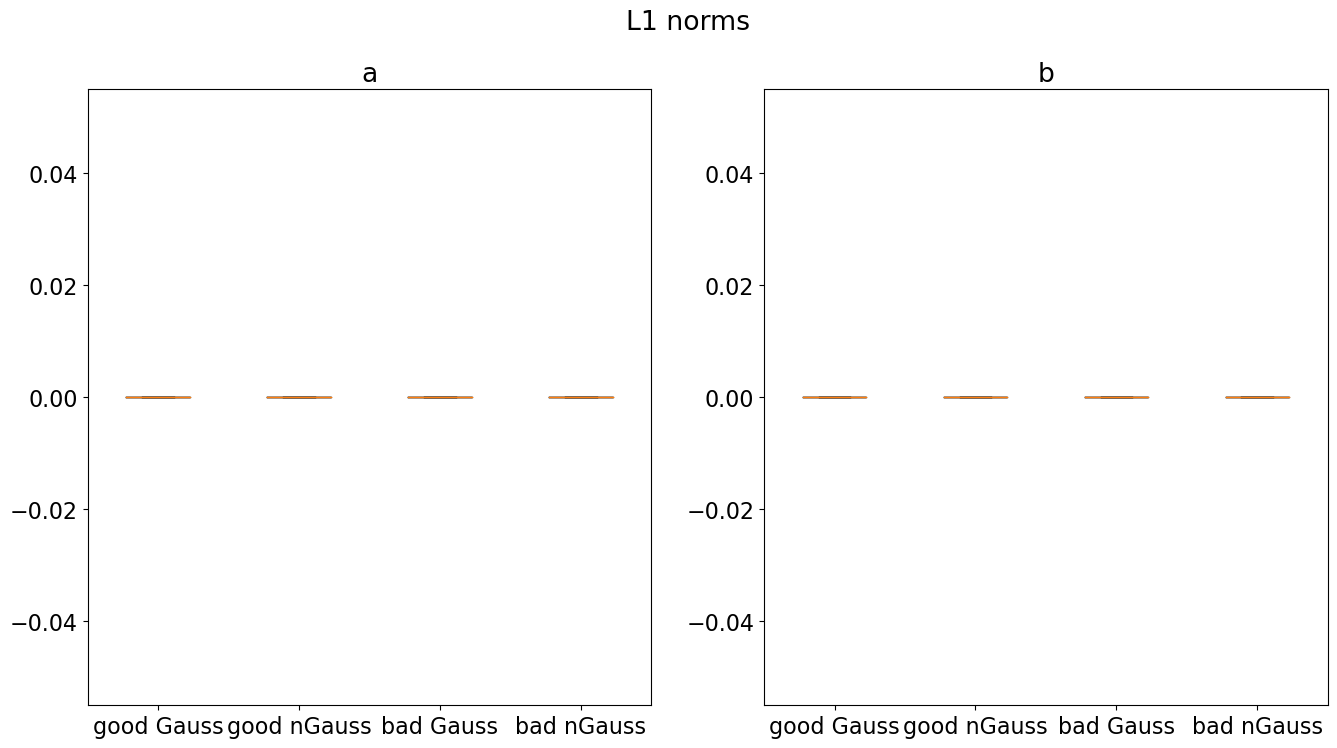

In [186]:
#font = {'size'   : 22}

plt.rc('font', **{'size'   : 16})
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].boxplot([norms[0,:],norms[2,:],norms[4,:],norms[6,:]])
ax[0].set_title("a")
ax[0].set_xticklabels(names)
 
ax[1].boxplot([norms[1,:],norms[3,:],norms[5,:],norms[7,:]])
ax[1].set_title("b")
ax[1].set_xticklabels(names)
          
fig.suptitle("L1 norms")
plt.savefig("crusher_results/CrusherBoxplot.pdf")
plt.show()

In [51]:
#grid search

n_samples = 10

start = 0
end = 2
grid = np.linspace(start,end,10000)
bc = BettiCurve(predefined_grid=grid)
labels = np.repeat([1,2,3,4], 2*n_samples)

def compute_curve_scores(dim, delay):
    if dim*delay > 48400:
        return 0
    betti_curves = np.zeros((len(signal_list),n_samples,len(grid)))
    for j in tqdm(range(0,len(signal_list))):


        #print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))

        skip =1
        samples = np.array_split(signal_list[j],n_samples)

        for k in range(0,len(samples)):
            #print(i,j,k)
            dgm = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = False, point_cloud_size = 100)
            #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
            curve = np.array(bc.fit_transform([dgm])[0])
            betti_curves[j,k] = curve
            #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
    
    clf = SVC(kernel="linear")
    #gaussian: 0145, non-gaussian:2367
    clf.fit([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
    return np.linalg.norm(clf.coef_[0])
    #return(silhouette_score(betti_curves.reshape(8*n_samples, len(grid)), labels))

def search_hyperbola(p):
    vals = np.geomspace(np.sqrt(p),np.sqrt(p)*p,int(p-112), dtype=int)
    labels = np.repeat([1,2,3,4], 2*n_samples)    
    scores = Parallel(n_jobs=-1)(delayed(compute_curve_scores)(vals[i], vals[-(i+1)]) for i in range(0,len(vals)))
                
    return np.array(scores)
    

#product = np.linspace(115,124,10)
dels = np.linspace(95,105,11)
dims = np.linspace(95,105,11)
#scores = Parallel(n_jobs=-1)(delayed(search_hyperbola)(p) for p in product)
scores = Parallel(n_jobs=-1)(delayed(compute_curve_scores)(int(i),int(j)) for i in dims for j in dels)

  0%|          | 0/8 [00:00<?, ?it/s]


In [52]:
print(dims, dels)
print(scores)
print(np.max(scores), np.argmax(scores))

[ 95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.] [ 95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.]
[0.05636785213905452, 0.023145895558856117, 0.02377992186538283, 0.0199266871106924, 0.0281104561001481, 0.028249559043074607, 0.02943105690755347, 0.032980866384934936, 0.033741658404789224, 0.021688159624962875, 0.01180760062397697, 0.02137600818483059, 0.01785674242885066, 0.026062287117816895, 0.019606914524071224, 0.03148806662781059, 0.032338942135539436, 0.02468541683613244, 0.02740420230800164, 0.02385530492416969, 0.014583736619086038, 0.012054393809114869, 0.0247523053210075, 0.02113896046904922, 0.0290302641316869, 0.016692117164307452, 0.015662164101200974, 0.03541457823369485, 0.029143995896816408, 0.008344500266817257, 0.02170036789995624, 0.013955312736426655, 0.017589473475589562, 0.026900757941533383, 0.028107695329645424, 0.02484666312429759, 0.005116478571789017, 0.021166011994419077, 0.04014834019876997, 0.014471424381411602, 0.010485637919018324, 0.0208

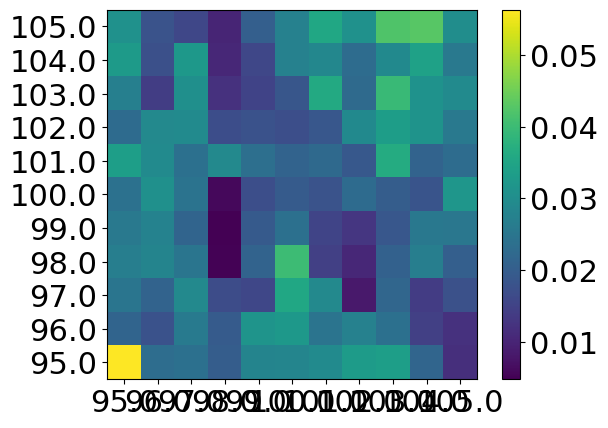

  0%|          | 0/8 [00:00<?, ?it/s]


In [53]:
np.array(scores).reshape((len(dims),len(dels)))
f,ax=plt.subplots()

img = ax.imshow(np.array(scores).reshape((len(dims),len(dels))), origin="lower")
plt.colorbar(img)

ax.set_xticks(range(len(dels)))
ax.set_yticks(range(len(dims)))
ax.set_xticklabels(dels)
ax.set_yticklabels(dims)

plt.show()

In [209]:
indices = set()
for p in product:
    indices = indices | set(np.geomspace(1,p*p,int(p/10), dtype=int))
    
indices = np.array(list(indices))
indices.sort()

   

NameError: name 'product' is not defined

In [210]:
df = pd.DataFrame(0, index=indices, columns=indices)

for i in range(len(scores)):
    p=product[i]
    vals = np.geomspace(1,p*p,int(p/10), dtype=int)
    for j in range(len(scores[i])):
        print(vals[j],vals[-(j+1)], scores[i][j])
        df.at[vals[j],vals[-(j+1)]] = scores[i][j]
        

df

AttributeError: 'numpy.ndarray' object has no attribute 'DataFrame'

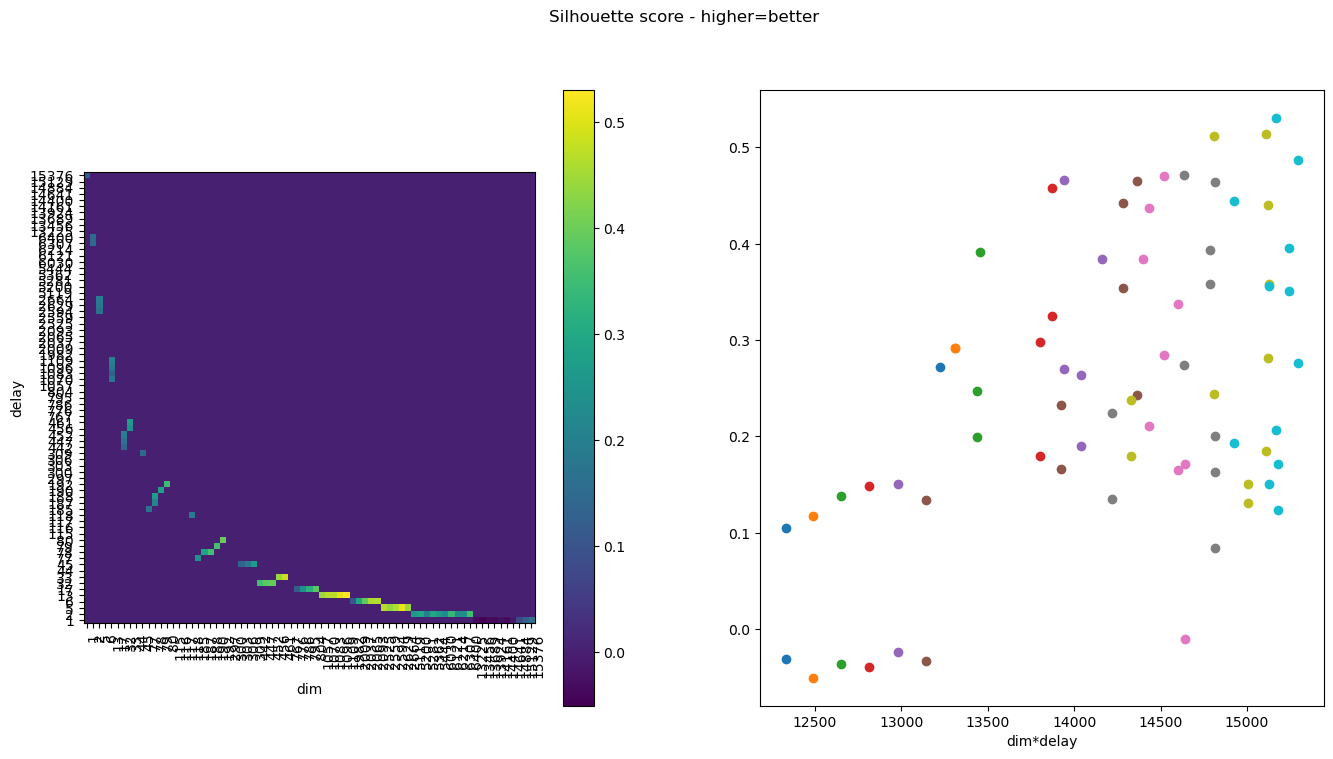

In [437]:
f,ax = plt.subplots(1,2,figsize=(16,8))
im = ax[0].imshow(df, origin="lower")
plt.colorbar(im)
ax[0].set_xticks(range(len(indices)))
ax[0].set_yticks(range(len(indices)))
ax[0].set_xticklabels(indices)
ax[0].set_yticklabels(indices)
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
ax[0].set_xlabel("dim")
ax[0].set_ylabel("delay")

for i in range(len(scores)):
    p = product[i]
    vals = np.geomspace(np.sqrt(p),np.sqrt(p)*p,int(p-112), dtype=int)
    ax[1].scatter(vals*np.flip(vals), scores[i])
ax[1].set_xlabel("dim*delay")

plt.suptitle("Silhouette score - higher=better")
plt.show()

In [119]:
clf = SVC(kernel="linear")
#gaussian
clf.fit([betti_curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
gauss_score = clf.score([betti_curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
clf.fit([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
ngauss_score = clf.score([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
print("gaussian score:", gauss_score)
print("non-gaussian score:", ngauss_score)

gaussian score: 1.0
non-gaussian score: 1.0


In [120]:
np.linalg.norm(clf.coef_[0])

0.005650430106582396

In [121]:
bcs = np.array([betti_curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)])
sum((bcs != 0).any(axis=0))


5265

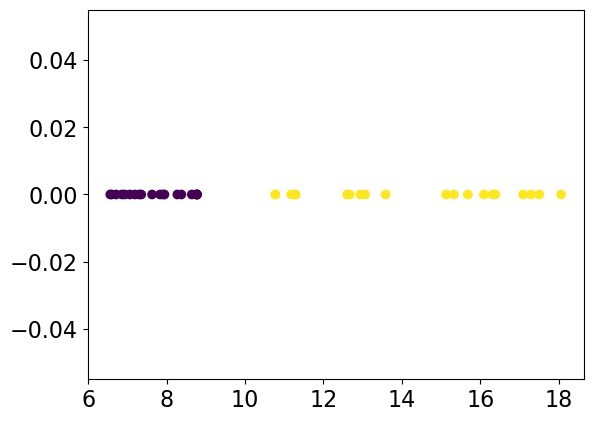

In [122]:
projection = np.dot(np.array([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)]), clf.coef_[0])
f,ax = plt.subplots()
ax.scatter(projection, [0]*40, c= np.repeat([0,1], 2*n_samples))
plt.show()

In [278]:
n_iterations = 100
#gauss
X=np.array([curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)])
y = np.repeat([0,1], 2*n_samples)
gauss_score_list = []
gauss_svnorm_list = []
for seed in range(n_iterations):
    clf = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed, stratify=y)
    #print(y_train.sum(), y_test.sum())
    clf.fit(X_train, y_train)
    gauss_score_list.append(clf.score(X_test, y_test))
    gauss_svnorm_list.append(np.linalg.norm(clf.coef_[0]))

#nGauss
X=np.array([curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)])
y = np.repeat([0,1], 2*n_samples)
from sklearn.model_selection import train_test_split
ngauss_score_list = []
ngauss_svnorm_list = []
for seed in range(n_iterations):
    clf = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed, stratify=y)
    #print(y_train.sum(), y_test.sum())
    clf.fit(X_train, y_train)
    ngauss_score_list.append(clf.score(X_test, y_test))
    ngauss_svnorm_list.append(np.linalg.norm(clf.coef_[0]))

Gauss mean, std: 0.932 0.060216276869298375
nGauss mean, std: 0.9610000000000001 0.045044422518220835


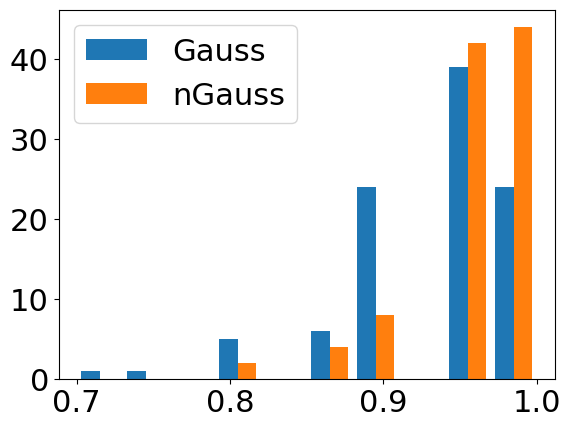

In [279]:
plt.hist([gauss_score_list, ngauss_score_list], label=(["Gauss", "nGauss"]))
plt.legend()
print("Gauss mean, std:", np.mean(gauss_score_list), np.std(gauss_score_list))
print("nGauss mean, std:", np.mean(ngauss_score_list), np.std(ngauss_score_list))

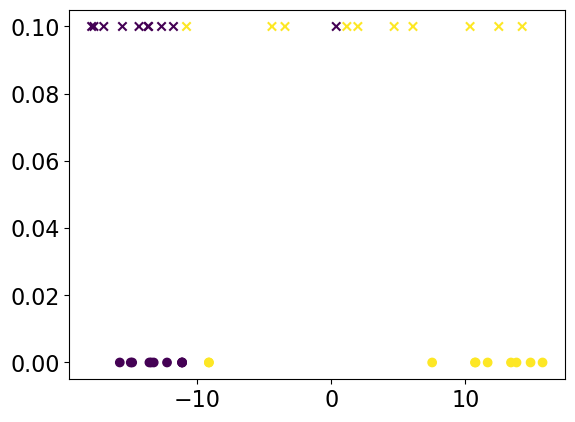

In [113]:
f,ax = plt.subplots()
projection = np.dot(X_train, clf.coef_[0])
ax.scatter(projection, [0]*20, c=y_train)
projection = np.dot(X_test, clf.coef_[0])
ax.scatter(projection, [0.1]*20, c=y_test, marker="x")


plt.show()